# Stock prices, dividends, splits and identifiers

- total returns, split-adjustments, identifier changes, share types
- SQL and Pandas

Copyright 2023, Terence Lim

MIT License

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.database import SQL, Redis
from finds.busday import BusDay
from finds.structured import CRSP, Finder
from finds.recipes import fractiles
from finds.display import show, plot_date
from yahoo import get_price
from conf import credentials, VERBOSE, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
imgdir = paths['images']

## Stock dividends and splits

In [3]:
ticker = 'AAPL'
find = Finder(sql)    # to search identifier lookup tables
find('AAPL')

,date,comnam,ncusip,shrcls,ticker,permno,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
0,19821101,APPLE COMPUTER INC,03783310,,AAPL,14593,20040609,11,3,3573,AAPL,0,Q,A,R,7
1,20040610,APPLE COMPUTER INC,03783310,,AAPL,14593,20070110,11,3,3573,AAPL,334111,Q,A,R,7
2,20070111,APPLE INC,03783310,,AAPL,14593,20171227,11,3,3571,AAPL,334111,Q,A,R,7
3,20171228,APPLE INC,03783310,,AAPL,14593,20220331,11,3,3571,AAPL,334220,Q,A,R,7


### Get price and distributions history from CRSP

In [4]:
found = find(ticker)      # locate names records by ticker
where = f" where permno = {found['permno'].iloc[-1]}"
dist = sql.read_dataframe(f"select * from {crsp['dist'].key} {where}")
crsp_df = sql.read_dataframe(f"select * from {crsp['daily'].key} {where}")\
             .set_index('date', inplace=False)
crsp_df

,permno,bidlo,askhi,prc,vol,ret,retx,bid,ask,shrout,openprc
date,,,,,,,,,,,
19801212,14593,28.750,28.875,-28.8125,NaN,NaN,NaN,NaN,NaN,55136,NaN
19801215,14593,27.250,27.375,-27.3125,NaN,-0.052061,-0.052061,NaN,NaN,55136,NaN
19801216,14593,25.250,25.375,-25.3125,NaN,-0.073227,-0.073227,NaN,NaN,55136,NaN
19801217,14593,25.875,26.000,-25.9375,NaN,0.024691,0.024691,NaN,NaN,55136,NaN
19801218,14593,26.625,26.750,-26.6875,NaN,0.028916,0.028916,NaN,NaN,55136,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20221230,14593,127.430,129.950,129.9300,76960600.0,0.002469,0.002469,NaN,NaN,16319441,128.41
20230103,14593,124.170,130.900,125.0700,112118000.0,-0.037405,-0.037405,NaN,NaN,16319441,130.28
20230104,14593,125.080,128.660,126.3600,89113600.0,0.010314,0.010314,NaN,NaN,16319441,126.89


### Retrieve price history from yahoo finance back to 1980

In [5]:
yahoo_df = get_price(ticker, start_date='19800101', verbose=VERBOSE)
yahoo_df.rename_axis(ticker)

cookies True crumb None
https://finance.yahoo.com/quote/^GSPC


,open,high,low,close,adjClose,volume,retx
AAPL,,,,,,,
19801215,0.12,0.12,0.12,0.12,0.09,175884800.0,NaN
19801216,0.11,0.11,0.11,0.11,0.09,105728000.0,0.916667
19801217,0.12,0.12,0.12,0.12,0.09,86441600.0,1.090909
19801218,0.12,0.12,0.12,0.12,0.09,73449600.0,1.000000
19801219,0.13,0.13,0.13,0.13,0.10,48630400.0,1.083333
...,...,...,...,...,...,...,...
20230104,126.89,128.66,125.08,126.36,126.36,89113600.0,1.010314
20230105,127.13,127.77,124.76,125.02,125.02,80962700.0,0.989395
20230106,126.01,130.29,124.89,129.62,129.62,87686600.0,1.036794


### Merge yahoo and CRSP by date

In [7]:
df = yahoo_df[['close', 'adjClose']]\
    .join(crsp_df[['prc', 'ret', 'retx', 'vol']]\
          .join(dist[dist['facpr'] != 0.0].set_index('exdt')['facpr'])\
          .join(dist[dist['divamt'] != 0.0].set_index('exdt')['divamt']),
          how='inner')\
    .drop(columns=['vol'])

### Select distribution dates where divamt and facpr are not NA

AAPL: 19801215-20230106
Cumulative dividend yield 0.2826
Cumulative stock split-adjustment 224.0
Cumulative total stock return multiple 1295.4


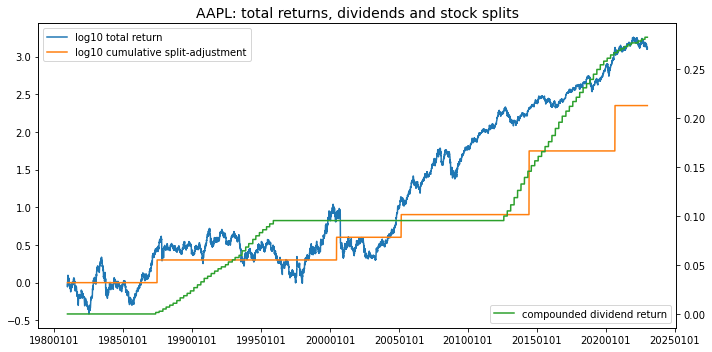

In [8]:
dist_dates = df.index[:1].append(df.index[~df['divamt'].isna()
                                          | ~df['facpr'].isna()])

print(f"{ticker}: {min(df.index)}-{max(df.index)}")
print('Cumulative dividend yield',
      ((1+(df['divamt']\
           .fillna(0)\
           .div(df['prc'].add(df['divamt'].fillna(0))))).prod() - 1).round(4))
print('Cumulative stock split-adjustment',
(df['facpr'].fillna(0) + 1).prod())
print('Cumulative total stock return multiple',
      ((df['ret'].fillna(0) + 1).prod()).round(1))

fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
plot_date(np.log10((df[['ret']].fillna(0) + 1).cumprod()
                   .join((df[['facpr']].fillna(0)+1).cumprod())),
          (1+(df['divamt']\
              .fillna(0)\
              .div(df['prc']\
                   .abs()\
                   .add(df['divamt']\
                        .fillna(0))))).cumprod() - 1,
          legend1=['log10 total return', 'log10 cumulative split-adjustment'],
          legend2=['compounded dividend return'],
          loc2='lower right',
          fontsize=10,
          ax=ax,
          title=ticker + ': total returns, dividends and stock splits')
plt.tight_layout()
plt.savefig(imgdir / 'splits.jpg')

## Reconcile split-adjusted Yahoo and CRSP prices
YAHOO
- close: split-adjusted price
- adjClose: split-adjust price, capital appreciation only (exclude dividend)

CRSP 
- prc: market closing price (negative if closing midquote)
- ret: total daily holding return
- retx: daily capital appreciation return
- facpr: factor to adjust price prior to ex-date
  - stocks splits and dividends: facpr = Shares(exdt) / Shares(exdt-1) - 1
  - reverse splits: -1 < facpr < 0
  - mergers and exchanges: facpr = -1, by convention
  - cash dividends and payments: facpr = 0
- divamt: dividend amount on ex-date

reconcile Yahoo and CRSP
- price: CRSP price adjusted by cumulative split factor
- adjprice: CRSP split-adjusted price excluding dividends

In [11]:
# Cumulate factor to adjust pre-split prices prior to ex-date
facpr = (1+df['facpr'].shift(-1)).sort_index(ascending=False)\
                                 .cumprod()\
                                 .fillna(method='ffill').fillna(1)

# Split-adjust CRSP market price by cumulative factor
df['price'] = df['prc'].abs().div(facpr)
                                                          
# Reduce CRSP split-adjusted price by dividend income
adjret = (1+df['retx']).cumprod().div(((1+df['ret'])).cumprod())
df['adjprice'] = df['price'].div(adjret) * adjret.iloc[-1] 

#show(df.loc[dist_dates].head(5), caption=ticker, **SHOW)
#show(df.loc[dist_dates[(dist_dates>19950816) & (dist_dates<20130207)]], **SHOW)
show(df.loc[dist_dates].tail(20), caption=ticker,**SHOW)

,close,adjClose,prc,ret,retx,facpr,divamt,price,adjprice
AAPL,,,,,,,,,
20180209,39.10,37.33,156.41,0.0122,0.0081,NaN,0.630,39.1025,37.3303
20180511,47.15,45.19,188.59,-0.0038,-0.0076,NaN,0.730,47.1475,45.1849
20180810,51.88,49.90,207.53,-0.0030,-0.0065,NaN,0.730,51.8825,49.8977
20181108,52.12,50.31,208.49,-0.0035,-0.0070,NaN,0.730,52.1225,50.3040
20190208,42.60,41.30,170.41,0.0012,-0.0031,NaN,0.730,42.6025,41.2923
20190510,49.29,47.97,197.18,-0.0138,-0.0176,NaN,0.770,49.2950,47.9656
20190809,50.25,49.08,200.99,-0.0082,-0.0120,NaN,0.770,50.2475,49.0797
20191107,64.86,63.54,259.43,0.0115,0.0085,NaN,0.770,64.8575,63.5382
20200207,80.01,78.57,320.03,-0.0136,-0.0159,NaN,0.770,80.0075,78.5686


## SQL: retrieve by share type codes and name substring
- all "INDEX" fund ETF's (share code 73)
- select from, max, min, where, like, group by, order by

In [17]:
funds = DataFrame(**sql.run("SELECT permno, MAX(comnam) as comnam, "
                            "    MAX(ncusip) as ncusip, MAX(ticker) as ticker, "
                            "    MIN(date) as date, MAX(nameendt) as nameendt, "
                            "    MAX(permco) as permco "
                            "  FROM names "
                            "  WHERE shrcd in (73) "
                            "    AND comnam LIKE '%% INDEX %%'"
                            "  GROUP BY permno"
                            "  ORDER BY permco"))
a = show(funds, latex=False)

     permno                            comnam    ncusip ticker      date  nameendt  permco
0     83208               WEBS INDEX FUND INC  92923H10    EWA  19970102  20000521   31600
1     83209               WEBS INDEX FUND INC  92923H20    EWO  19970102  20000521   31600
2     83210               WEBS INDEX FUND INC  92923H30    EWK  19970102  20000521   31600
3     83211               WEBS INDEX FUND INC  92923H40    EWC  19970102  20000521   31600
4     83212               WEBS INDEX FUND INC  92923H50    EWQ  19970102  20000521   31600
5     83213               WEBS INDEX FUND INC  92923H60    EWG  19970102  20000521   31600
6     83215               WEBS INDEX FUND INC  92923H70    EWH  19970102  20000521   31600
7     83216               WEBS INDEX FUND INC  92923H79    EWU  19970102  20000521   31600
8     83217               WEBS INDEX FUND INC  92923H80    EWI  19970102  20000521   31600
9     83218               WEBS INDEX FUND INC  92923H81    EWL  19970102  20000521   31600

## SQL and Pandas: find currently-active stocks with most ticker changes

In [28]:
counts = DataFrame(**sql.run('SELECT permno, '
                             '  MAX(nameendt) as enddate, '
                             '  COUNT(DISTINCT ticker) as counts '
                             '  FROM names '
                             '  WHERE shrcd in (10, 11) '
                             '    AND exchcd in (1, 2, 3) '
                             '  GROUP BY permno'
                             '  ORDER BY counts, enddate'))
# require to still be listed at latest date
counts = counts[counts['enddate'].eq(counts['enddate'].max())]

# select permnos with most number of ticker changes
permnos = counts[counts['counts'].eq(counts['counts'].max())]['permno'].to_list()
print(permnos)

# show all record fields for selected permnos
df = DataFrame(**sql.run(f"SELECT * from names " +
                         f"WHERE permno IN ({permnos[-1]})"))\
                         .sort_values(['permno', 'date'])
show(df, **SHOW)

[64899, 86990]


,date,comnam,ncusip,shrcls,ticker,permno,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
0,19990611,PHONE COM INC,71920Q10,,PHCM,86990,20001119,11,3,3660,PHCM,0,Q,A,R,16581
1,20001120,OPENWAVE SYSTEMS INC,68371810,,OPWV,86990,20031021,11,3,7372,OPWV,0,Q,A,R,16581
2,20031022,OPENWAVE SYSTEMS INC,68371830,,OPWV,86990,20031118,11,3,7372,OPWVD,0,Q,A,R,16581
3,20031119,OPENWAVE SYSTEMS INC,68371830,,OPWV,86990,20040609,11,3,7372,OPWV,0,Q,A,R,16581
4,20040610,OPENWAVE SYSTEMS INC,68371830,,OPWV,86990,20120508,11,3,7372,OPWV,511210,Q,A,R,16581
5,20120509,UNWIRED PLANET INC,91531F10,,UPIP,86990,20160105,11,3,7372,UPIP,511210,Q,A,R,16581
6,20160106,UNWIRED PLANET INC,91531F20,,UPIP,86990,20160616,11,3,7372,UPIP,511210,Q,A,R,16581
7,20160617,GREAT ELM CAPITAL GROUP INC,39036P10,,GEC,86990,20161124,11,3,7372,GEC,511210,Q,A,R,16581
8,20161125,GREAT ELM CAPITAL GROUP INC,39036P20,,GECX,86990,20161226,11,3,7372,GECX,511210,Q,A,R,16581
9,20161227,GREAT ELM CAPITAL GROUP INC,39036P20,,GEC,86990,20201228,11,3,7372,GEC,511210,Q,A,R,16581


## SQL and Pandas: missing and average delisting returns, by delisting code
- join on, subqueries

In [29]:
# Usual filter by share (US stocks) and exchange (NYSE, Amex, Nasdaq) codes
DataFrame(**sql.run("SELECT t1.* FROM names t1 INNER JOIN "
                    "  (SELECT permno, MAX(date) as date "
                    "  FROM names GROUP BY permno) t2 "
                    "  ON t1.permno = t2.permno AND t1.date = t2.date"
                    "    WHERE shrcd in (10, 11) AND exchcd in (1, 2, 3)"))

,date,comnam,ncusip,shrcls,ticker,permno,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
0,19251231,AHUMADA LEAD CO,,,,10081,19310618,10,1,1000,,0,N,A,R,22163
1,19251231,AJAX RUBR INC,,,,10110,19310214,10,1,3010,,0,N,A,R,22165
2,19251231,ALL AMER CABLES INC,,,,10129,19270401,10,1,4820,,0,N,A,R,22167
3,19251231,AMERICAN EXPRESS CO,,,,10284,19390731,10,1,7390,,0,N,A,R,90
4,19251231,AMERICAN DRUGGISTS SYND,,,,10305,19290110,10,1,2830,,0,N,A,R,22182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26198,20220329,PINEAPPLE HOLDINGS INC,72303P10,,PEGY,25452,20220331,11,3,3660,PEGY,334210,Q,A,R,5195
26199,20220329,WILLIAMS INDUSTRIAL SRVCS GP INC,96951A10,,WLMS,88987,20220331,11,2,3568,WLMS,333613,A,A,R,41577
26200,20220329,HERITAGE CRYSTAL CLEAN INC,42726M10,,HCCI,92588,20220331,11,3,4955,HCCI,562998,Q,A,R,52968
26201,20220330,DIAMOND OFFSHORE DRILLING INC,25271C20,,DO,22928,20220331,11,1,1381,DO,213111,N,A,R,30963


### Last delisting after 1962, by permno

DataFrame(**sql.run("SELECT t1.* FROM delist t1 INNER JOIN "
                    "  (SELECT permno, MAX(dlstdt) as dlstdt "
                    "    FROM delist GROUP BY permno) t2 "
                    "  ON t1.permno = t2.permno AND t1.dlstdt = t2.dlstdt "
                    "    WHERE t2.dlstdt > 19621231"))

### Inner join of sub-quries

In [30]:
df = DataFrame(**sql.run("SELECT u1.permno, u2.dlstcd, u2.dlret FROM"
                        "  (SELECT t1.* FROM names t1 INNER JOIN "
                        "    (SELECT permno, MAX(date) as date FROM names"
                        "        GROUP BY permno) t2 "
                        "      ON t1.permno = t2.permno "
                        "        AND t1.date = t2.date "
                        "      WHERE shrcd in (10, 11) "
                        "        AND exchcd in (1, 2, 3)) u1"
                        "  INNER JOIN"
                        "  (SELECT t1.* FROM delist t1 INNER JOIN "
                        "    (SELECT permno, MAX(dlstdt) as dlstdt "
                        "      FROM delist GROUP BY permno) t2 "
                        "    ON t1.permno = t2.permno "
                        "      AND t1.dlstdt = t2.dlstdt "
                        "    WHERE t2.dlstdt > 19621231) u2"
                        "  ON u1.permno = u2.permno"))
# Pandas: summarize by delisting code
df.groupby('dlstcd').agg({'dlret': ['count', 'size', 'mean']})\
                    .assign(frac_miss=lambda x: ((x.iloc[:,1] - x.iloc[:,0])
                                                 / x.iloc[:,1]))\
                    .round(4)

dlret               frac_miss
       count  size    mean          
dlstcd                              
160        0     3     NaN    1.0000
200      377   378  0.0240    0.0026
231     4104  4105  0.0178    0.0002
232       18    27  0.0856    0.3333
233     5947  5950  0.0102    0.0005
234       11    23  0.0010    0.5217
235        2     2  0.2692    0.0000
241      823   823  0.0172    0.0000
242      158   169  0.0013    0.0651
243       13    13 -0.0643    0.0000
244       17    19  0.0326    0.1053
251        9    10  0.0594    0.1000
252        3     6  0.0308    0.5000
261      118   149  0.0191    0.2081
262        3     7  0.0076    0.5714
271        2     2  0.0483    0.0000
280        2     2  0.0296    0.0000
290        0     1     NaN    1.0000
300      428   428  0.0162    0.0000
331      166   166 -0.0217    0.0000
332        3     3  0.0890    0.0000
333        1     1  0.0000    0.0000
334        0     1     NaN    1.0000
341       11    11  0.0458    0.0000
342        6     7 -0.1701    0.1429
343        1     1 -0.0296    0.0000
350        5     5  0.0304    0.0000
400        1     3 -0.5454    0.6667
450      259   260  0.1701    0.0038
460       26    49 -0.2476    0.4694
470        0    30     NaN    1.0000
480        0     1     NaN    1.0000
490        4     4 -0.7212    0.0000
500      260   992 -0.1828    0.7379
505        1     2 -0.0271    0.5000
510        3    34  0.0846    0.9118
513        1     2 -0.2857    0.5000
516        5    16 -0.0157    0.6875
517        2     3 -0.0500    0.3333
519        0     2     NaN    1.0000
520      175   240 -0.1051    0.2708
550      223   436 -0.0059    0.4885
551      109   190 -0.0651    0.4263
552      941   993 -0.1179    0.0524
560     1087  1320 -0.0802    0.1765
561      574   667 -0.1147    0.1394
570      326   407 -0.0819    0.1990
573       76    95 -0.0613    0.2000
574      553   771 -0.3659    0.2827
575        8    13 -0.0102    0.3846
580      701   951 -0.1474    0.2629
581       57    71 -0.0194    0.1972
582      139   169 -0.1267    0.1775
583        7    10 -0.0704    0.3000
584      632   922 -0.2215    0.3145
585      123   163 -0.1242    0.2454
587       16    16 -0.0851    0.0000
589        3    11 -0.1817    0.7273
591       15    30 -0.6291    0.5000